# Question 2

This dataset provides monthly operational metrics for a major Indian airline
from 2013. It includes information on the number of departures, flight hours,
distance flown, passenger traffic, available seat kilometers, freight carried,
and mail carried. You can use any popular time series library for this task.

In [1774]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from jupyterthemes.jtplot import figsize
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import statsmodels.api as sm

data = pd.read_csv('AirtrafficA4.csv')

Removing `null` values out of the data, adding a new `timestamp` column showing month + year in a specific formate.

In [1775]:
data['MONTH'] = data['MONTH'].str.strip().replace({ 'JUNE': 'JUN', 'JULY': 'JUL' }).astype(str)
data['YEAR'] = data['YEAR'].astype(str)
data['TIMESTAMP'] = pd.to_datetime(data['YEAR'] + '-' + data['MONTH'] + '-01', format='%Y-%b-%d')
data.fillna(0, inplace=True)

Making `TIMESTAMP` as the index and sorting according to it, so I can plot easily

In [1776]:
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
data.set_index('TIMESTAMP', inplace=True)
data = data.asfreq('MS')
data.sort_index(inplace=True)
data['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED'].astype(str).str.replace(',', '').astype(float)
data['COVID PERIOD'] = ((data.index >= '2020-03-01') & (data.index <= '2022-03-01')).astype(bool)
data.to_csv('Temp.csv')

Plotting a graph of passengers carried by the plan each month

In [1777]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()


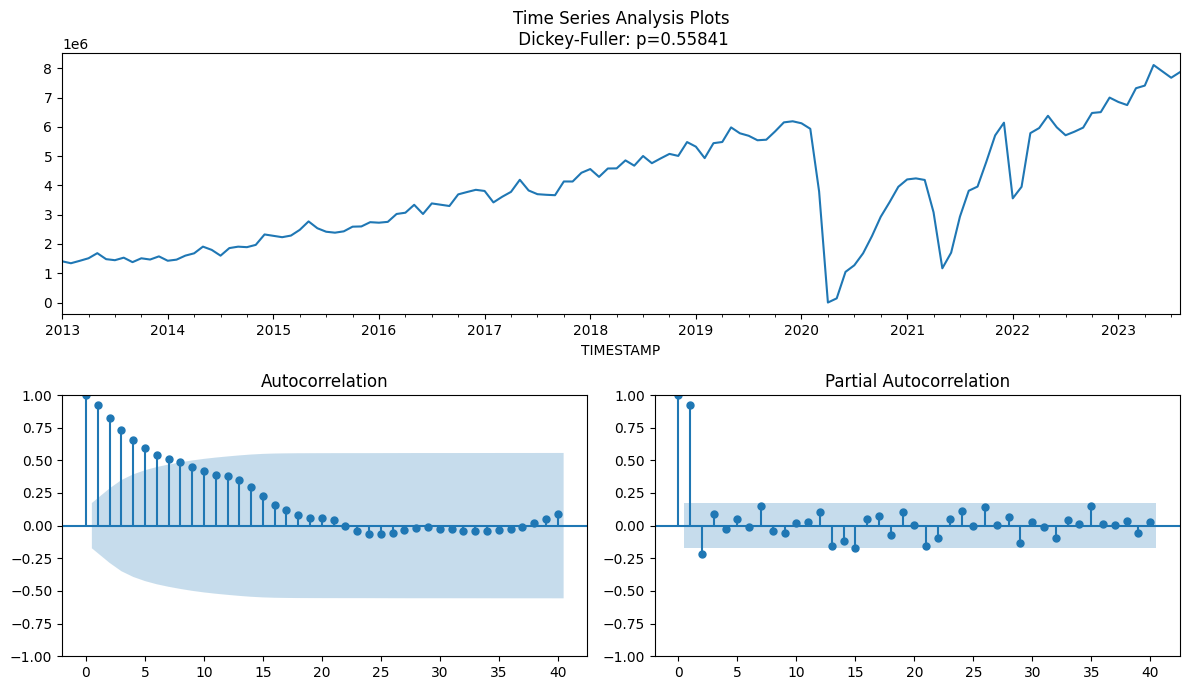

In [1778]:
tsplot(data['PASSENGERS CARRIED'], lags=40)

Let's try interpolating data during COVID

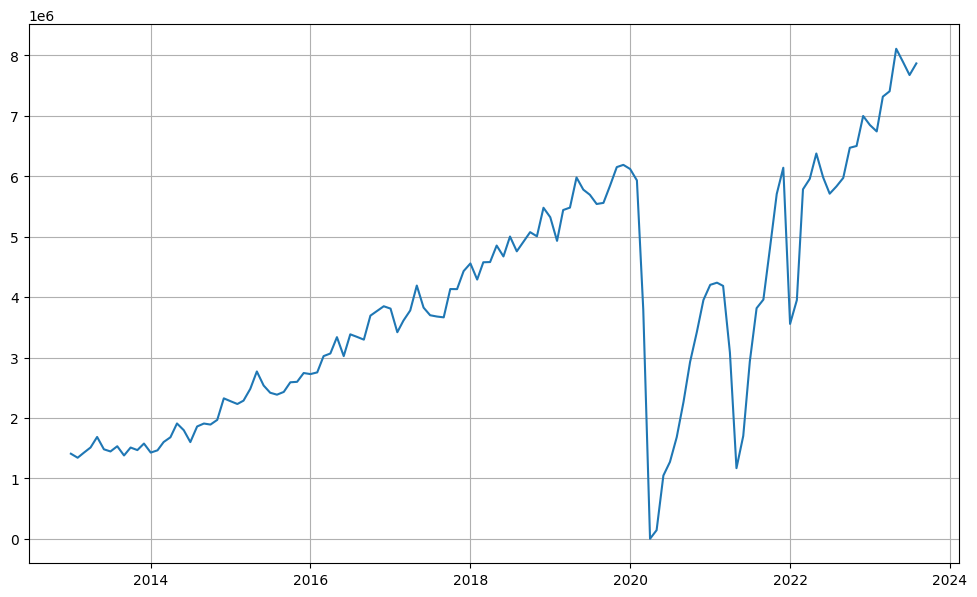

In [1779]:
# data['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED'].where(~(data['COVID PERIOD']), np.nan)
# data['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED'].ffill() 
# 
# decomposition = seasonal_decompose(data['PASSENGERS CARRIED'], model='additive', period=12)
# seasonal = decomposition.seasonal
# trend = decomposition.trend
# residual = decomposition.resid
# 
# seasonal_interpolated = seasonal.where(~(data['COVID PERIOD']), np.nan).interpolate(method='time')
# data['PASSENGERS CARRIED'] = trend + seasonal_interpolated + residual

plt.figure(figsize=(12, 7))
plt.plot(data.index, data['PASSENGERS CARRIED'])
plt.grid(True)
plt.show()

To remove the trend, we can use differencing. Let's plot the differenced data

In [1780]:
data['LOG_PASSENGERS'] = np.log(data['PASSENGERS CARRIED'].apply(lambda x: x+1 if x == 0 else -x if x < 0 else x))
data['FIRST_DIFF'] = data['LOG_PASSENGERS'].diff(periods=12)
data['DIFF_PASSENGERS'] = data['FIRST_DIFF']
data.dropna(inplace=True)


Since the data is sorted according to `TIMESTAMP`, let's just split it into training and testing data


In [1781]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

train.to_csv('Train.csv')
test.to_csv('Test.csv')

Let's plot ACF, PACF for AR(p) and MA(q) models.

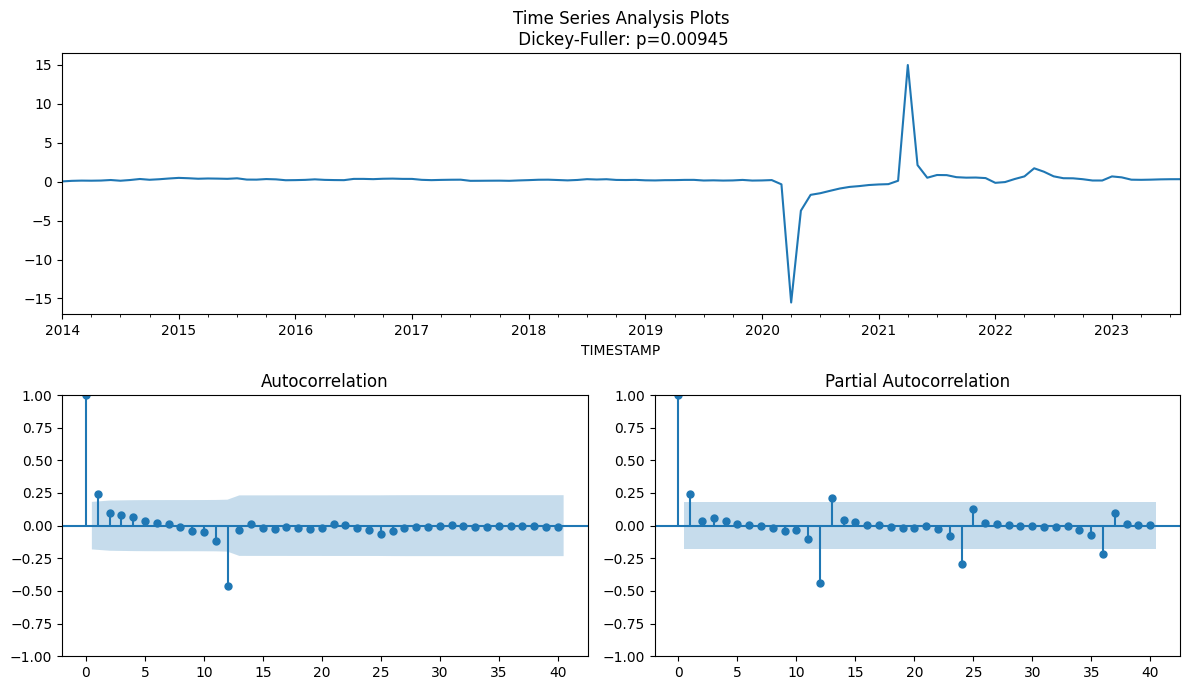

In [1782]:
tsplot(data['DIFF_PASSENGERS'], lags=40)

Since there is seasonality here, let's try an AutoARIMA model

/home/awez_mehtab/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


MAE: 1.5732232551778853, MAPE: 4.083558952435475


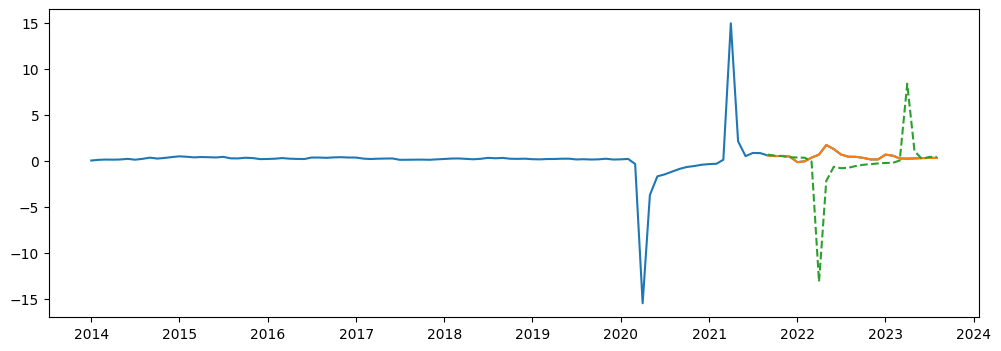

In [1783]:
model = SARIMAX(train['DIFF_PASSENGERS'], order=(0, 1, 0), seasonal_order=(1, 1, 1, 12), freq='MS')
sarima_fit = model.fit(disp=False)

predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

mae = mean_absolute_error(test['DIFF_PASSENGERS'], predictions)
mape = mean_absolute_percentage_error(test['DIFF_PASSENGERS'], predictions)
print(f'MAE: {mae}, MAPE: {mape}')

plt.figure(figsize=(12, 4))
plt.plot(data['DIFF_PASSENGERS'], label='Train')
plt.plot(test.index, test['DIFF_PASSENGERS'], label='Test')
plt.plot(test.index, predictions, label='Predictions', linestyle='--')

Using it to predict the `PASSENGERS CARRIED` from 2023 SEP to 2024 AUG

In [1784]:
data_range = pd.date_range(start='2023-09-01', end='2024-08-01', freq='MS')
future_data = pd.DataFrame(index=data_range, columns=['PASSENGERS CARRIED'])

predicted_diffs = sarima_fit.predict(start=len(train), end=len(train) + len(data_range) - 1, dynamic=False)

level_1_diff_reversed = []
level_12_diff_reversed = []

last_log_val12 = data['LOG_PASSENGERS'].iloc[-12:]
last_log_val1 = data['FIRST_DIFF'].iloc[-1]

for i, pred in enumerate(predicted_diffs):
    if i == 0:
        value = pred + last_log_val1
    else:
        value = pred + level_1_diff_reversed[-1]
    level_1_diff_reversed.append(value)
    
print(level_1_diff_reversed)
    
for i, value in enumerate(level_1_diff_reversed):
    if i < 12:
        final_value = value + last_log_val12[i]
    else:
        final_value = value + level_12_diff_reversed[i - 12]
    level_12_diff_reversed.append(final_value)
    
print(level_12_diff_reversed)
    
future_data['PASSENGERS CARRIED'] = [int(np.exp(x) - 1) for x in level_12_diff_reversed]
future_data['YEAR_MONTH'] = future_data.index.strftime('%Y %b').str.upper()
future_data.to_csv('Future.csv')
future_data = future_data[['YEAR_MONTH', 'PASSENGERS CARRIED']]
future_data.to_csv('Future.csv')
future_data

[0.9554631397351849, 1.487386096272881, 1.970245229313052, 2.339251021546982, 2.679886767377975, 2.9918100988042866, 2.9024807616212054, -10.269381812572574, -12.475053312110825, -13.144831682147409, -13.969377414897064, -14.73918058049887]
[16.55813075874311, 17.170295458198787, 17.657696877606924, 18.100310520481642, 18.419264006864623, 18.715669560705834, 18.708231087106377, 5.548478637406486, 3.4335089970111117, 2.736692667423645, 1.8840871041902059, 1.1390396946043815]


/tmp/ipykernel_6899/2948093349.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_value = value + last_log_val12[i]


,YEAR_MONTH,PASSENGERS CARRIED
2023-09-01,2023 SEP,15527616
2023-10-01,2023 OCT,28639442
2023-11-01,2023 NOV,46627304
2023-12-01,2023 DEC,72588023
2024-01-01,2024 JAN,99858425
2024-02-01,2024 FEB,134311132
2024-03-01,2024 MAR,133315769
2024-04-01,2024 APR,255
2024-05-01,2024 MAY,29
2024-06-01,2024 JUN,14
